
Dtypes:
 fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
type                     object
dtype: object

Counts by type:
 type
white    3961
red      1359
Name: count, dtype: int64

Quality distribution:
 quality
3      30
4     206
5    1752
6    2323
7     856
8     148
9       5
Name: count, dtype: int64
Duplicates removed: 1177
Final shape: (5320, 13)

Counts by type:
 type
white    3961
red      1359
Name: count, dtype: int64

Quality distribution:
 quality
3      30
4     206
5    1752
6    2323
7     856
8     148
9       5
Name: count, dtype: int64


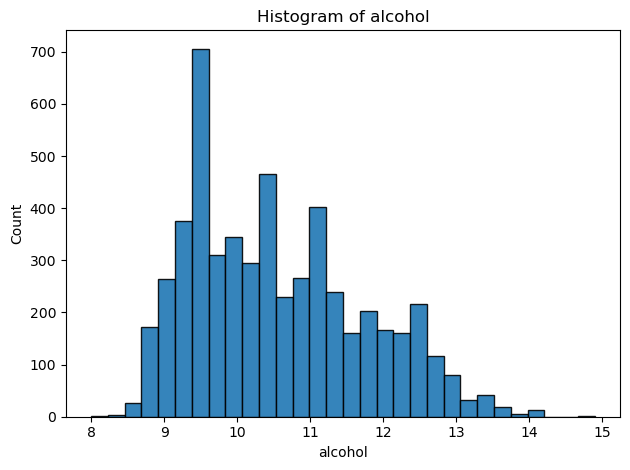

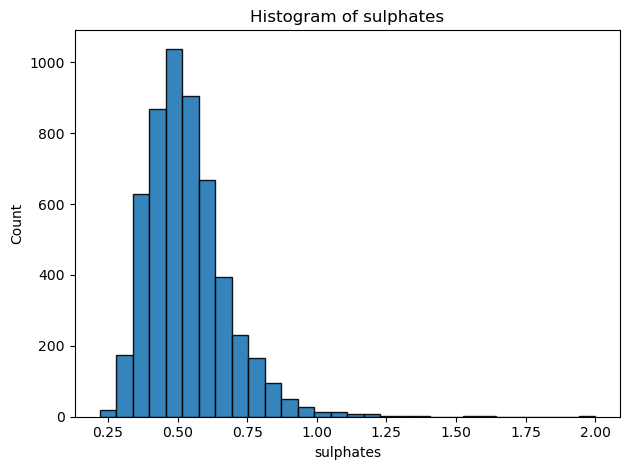

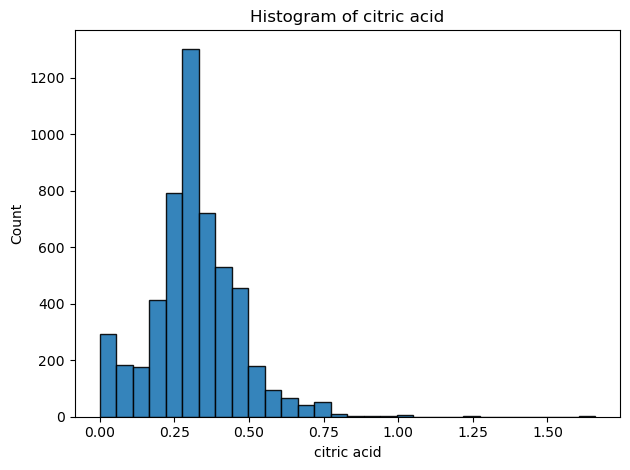

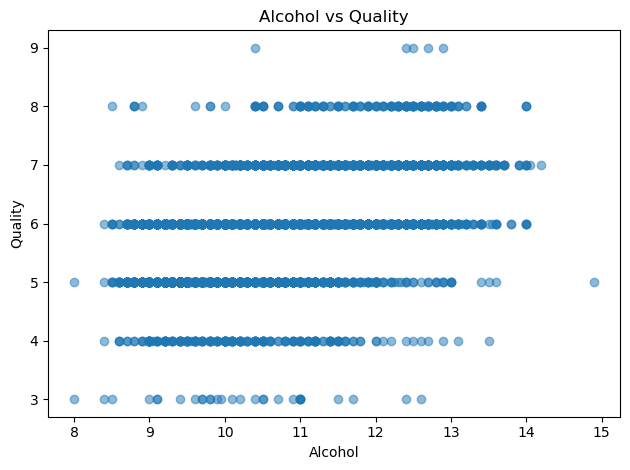

Baseline RMSE (mean predictor): 0.880
Train shape: (4256, 11) | Test shape: (1064, 11)

[Linear Regression] Test RMSE: 0.724
Alpha =  0.1: CV RMSE = 0.738
Alpha =  1.0: CV RMSE = 0.738
Alpha = 10.0: CV RMSE = 0.738

[Ridge] α = 1 | CV RMSE = 0.738 | Test RMSE = 0.724


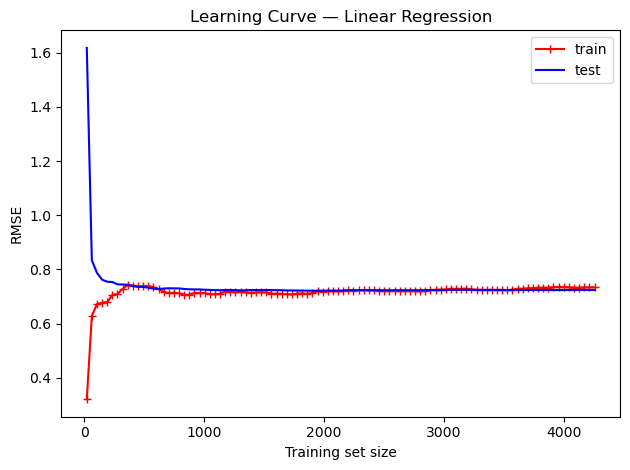

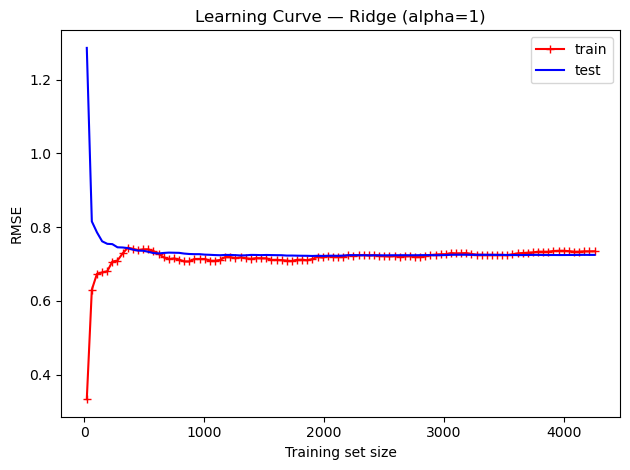

As shown from the test RMSE of both the Ridge and Linear regression were 0.724 so Ridge regression did not provided any improvment over Linear regression on this data set 

Components for ≥90% variance: 8


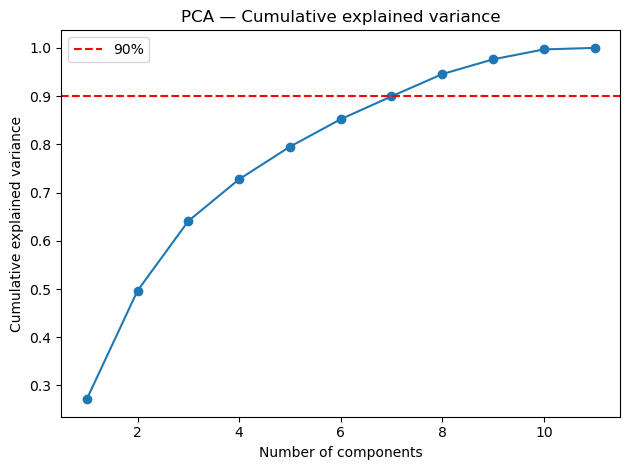

PCA components (90%): 7

[Logistic Regression] Accuracy: 0.821
k =  1 | Accuracy = 0.802
k =  2 | Accuracy = 0.824
k =  3 | Accuracy = 0.830
k =  4 | Accuracy = 0.830
k =  5 | Accuracy = 0.817
k =  6 | Accuracy = 0.836
k =  7 | Accuracy = 0.832
k =  8 | Accuracy = 0.836
k =  9 | Accuracy = 0.835
k = 10 | Accuracy = 0.836
k = 11 | Accuracy = 0.838
k = 12 | Accuracy = 0.841
k = 13 | Accuracy = 0.839
k = 14 | Accuracy = 0.834
k = 15 | Accuracy = 0.831

Best k: 12 | Accuracy: 0.841


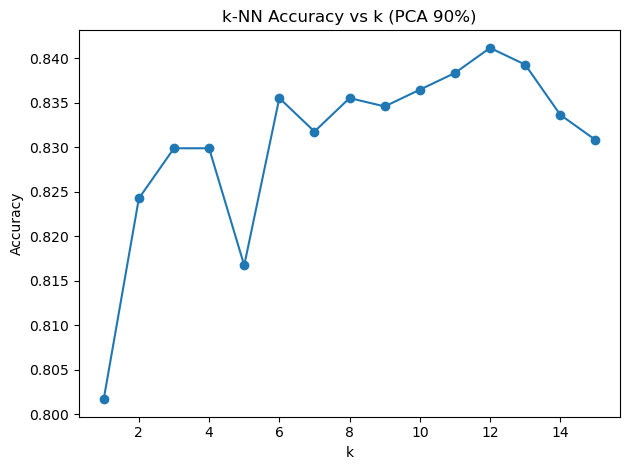


Confusion Matrix (k = 12):
             Predicted Low  Predicted High
Actual Low             832              30
Actual High            139              63
k = 2 | inertia = 46095.46202339502
k = 3 | inertia = 37914.900965549896
k = 4 | inertia = 33828.60074279735
k = 5 | inertia = 31544.246589656126
k = 6 | inertia = 29583.988930642998


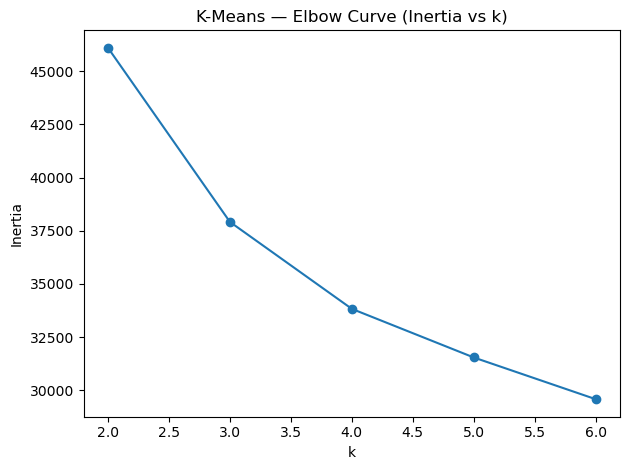

Explained variance (PC1+PC2): 0.497


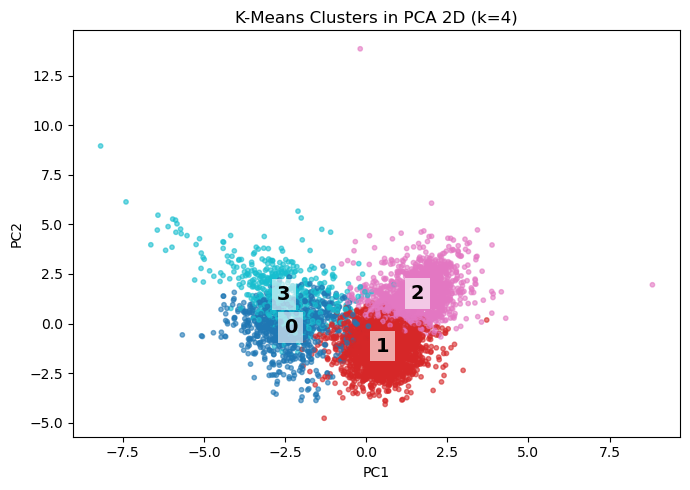


Counts by cluster and type:
 type     red  white
cluster            
0        774     80
1         38   2435
2          4   1402
3        543     44

Cluster quality summary:
          count      mean
cluster                 
0          854  5.384075
1         2473  6.065507
2         1406  5.571124
3          587  5.795571


In [2]:
# Dataset source:
# Cortez, P., Cerdeira, A., Almeida, F., Matos, T., & Reis, J. (2009).
# Modeling wine preferences by data mining from physicochemical properties.
# UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Wine+Quality


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans


# Load
red   = pd.read_csv("winequality-red.csv", sep=";")
white = pd.read_csv("winequality-white.csv", sep=";")

# Merge
red["type"] = "red"
white["type"] = "white"
df = pd.concat([red, white], ignore_index=True)

# Drop exact duplicates
before = len(df)
df = df.drop_duplicates()
after = len(df)

# Quick checks to see 
print("\nDtypes:\n", df.dtypes)
print("\nCounts by type:\n", df["type"].value_counts())
print("\nQuality distribution:\n", df["quality"].value_counts().sort_index())


print("Duplicates removed:", before - after)
print("Final shape:", df.shape)

print("\nCounts by type:\n", df["type"].value_counts())
print("\nQuality distribution:\n", df["quality"].value_counts().sort_index())


# task 1 
features = ["alcohol", "sulphates", "citric acid"]
for feat in features:
    ax = df[feat].plot(kind="hist", bins=30, alpha=0.9, edgecolor="black")
    ax.set_title(f"Histogram of {feat}")
    ax.set_xlabel(feat); ax.set_ylabel("Count")
    plt.tight_layout(); plt.show()

plt.scatter(df["alcohol"], df["quality"], alpha=0.5)
plt.title("Alcohol vs Quality"); plt.xlabel("Alcohol"); plt.ylabel("Quality")
plt.tight_layout(); plt.show()

# Baseline mean predictor
y = df["quality"].astype(float).values
rmse_base = np.sqrt(mean_squared_error(y, np.full_like(y, y.mean())))
print("Baseline RMSE (mean predictor): {:.3f}".format(rmse_base))

# Data split 
X = df.drop(columns=["quality", "type"]).values
y = df["quality"].astype(float).values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)

# Linear Regression
lin_reg = LinearRegression().fit(X_train, y_train)
rmse_lin = np.sqrt(mean_squared_error(y_test, lin_reg.predict(X_test)))
print("\n[Linear Regression] Test RMSE: {:.3f}".format(rmse_lin))

# Ridge (tune alpha = {0.1,1,10}) with 5-fold CV on tarin only 
alphas = [0.1, 1.0, 10.0]
cv_scores = []
for a in alphas:
    pipe = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha=a, random_state=42))])
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
    rmse_cv = np.sqrt(-scores.mean())
    cv_scores.append((a, rmse_cv))
    print("Alpha = {:>4}: CV RMSE = {:.3f}".format(a, rmse_cv))

# this will pick the best alpha tp use
best_alpha, best_cv = sorted(cv_scores, key=lambda t: (t[1], abs(t[0]-1.0)))[0]

pipe_best = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha=best_alpha, random_state=42))])
pipe_best.fit(X_train, y_train)
rmse_ridge = np.sqrt(mean_squared_error(y_test, pipe_best.predict(X_test)))
print("\n[Ridge] α = {} | CV RMSE = {:.3f} | Test RMSE = {:.3f}".format(best_alpha, best_cv, rmse_ridge))

# Learning curves function so i can use it on the different regression with the samestyle 

def plot_learning_curves(model, X_train, y_train, X_test, y_test, title):
    sizes = np.linspace(20, len(X_train), num=100, dtype=int)
    tr, te = [], []
    for m in sizes:
        model.fit(X_train[:m], y_train[:m])
        tr.append(np.sqrt(mean_squared_error(y_train[:m], model.predict(X_train[:m]))))
        te.append(np.sqrt(mean_squared_error(y_test,     model.predict(X_test))))
    plt.plot(sizes, tr, "r-+", label="train")
    plt.plot(sizes, te, "b-",  label="test")
    plt.title(title); plt.xlabel("Training set size"); plt.ylabel("RMSE")
    plt.legend(); plt.tight_layout(); plt.show()

plot_learning_curves(lin_reg,   X_train, y_train, X_test, y_test, "Learning Curve — Linear Regression")
plot_learning_curves(pipe_best, X_train, y_train, X_test, y_test, f"Learning Curve — Ridge (alpha={best_alpha})")

print("As shown from the test RMSE of both the Ridge and Linear regression were 0.724 so Ridge regression did not provided any improvment over Linear regression on this data set \n")


# task 2 CLassification with PCA 

X = df.drop(columns=["quality", "type"]).values

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

pca_full = PCA().fit(X_std)
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
d90 = np.argmax(cumsum >= 0.90) + 1
print("Components for ≥90% variance:", d90)

plt.plot(np.arange(1, len(cumsum)+1), cumsum, marker="o")
plt.axhline(0.90, color="r", linestyle="--", label="90%")
plt.xlabel("Number of components"); plt.ylabel("Cumulative explained variance")
plt.title("PCA — Cumulative explained variance"); plt.legend(); plt.tight_layout(); plt.show()

# Label: high quality >= 7
y = (df["quality"] >= 7).astype(int).values
X = df.drop(columns=["quality", "type"]).values

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

scaler = StandardScaler().fit(X_tr)
X_tr_std = scaler.transform(X_tr)
X_te_std = scaler.transform(X_te)

pca = PCA(n_components=0.90).fit(X_tr_std)
X_tr_pca = pca.transform(X_tr_std)
X_te_pca = pca.transform(X_te_std)
print("PCA components (90%):", pca.n_components_)

# Logistic Regression
lr = LogisticRegression(max_iter=2000, solver="lbfgs").fit(X_tr_pca, y_tr)
acc_lr = accuracy_score(y_te, lr.predict(X_te_pca))
print("\n[Logistic Regression] Accuracy: {:.3f}".format(acc_lr))

# k-NN sweep
k_vals, accs = range(1, 16), []
best_k, best_acc, best_pred = None, -1, None
for k in k_vals:
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_tr_pca, y_tr)
    pred = knn.predict(X_te_pca)
    acc  = accuracy_score(y_te, pred)
    accs.append(acc)
    if acc > best_acc: best_k, best_acc, best_pred = k, acc, pred
    print("k = {:>2} | Accuracy = {:.3f}".format(k, acc))

print("\nBest k:", best_k, "| Accuracy: {:.3f}".format(best_acc))

# Accuracy vs k
plt.plot(list(k_vals), accs, marker="o")
plt.title("k-NN Accuracy vs k (PCA 90%)")
plt.xlabel("k"); plt.ylabel("Accuracy")
plt.tight_layout(); plt.show()

# Confusion matrix for best k
cm = confusion_matrix(y_te, best_pred)
cm_df = pd.DataFrame(cm,
                     index=["Actual Low", "Actual High"],
                     columns=["Predicted Low", "Predicted High"])

print(f"\nConfusion Matrix (k = {best_k}):")
print(cm_df)

# task 3 — K-Means Clustering (4 marks)
X = df.drop(columns=["quality", "type"]).values
X_std = StandardScaler().fit_transform(X)

# Task 3.1: Choosing k via elbow (k=2-6)
ks = range(2, 7)
inertias = []
for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)  # was 10 + parallel_backend
    km.fit(X_std)
    inertias.append(km.inertia_)
    print("k =", k, "| inertia =", km.inertia_)

plt.plot(list(ks), inertias, marker="o")
plt.title("K-Means — Elbow Curve (Inertia vs k)")
plt.xlabel("k"); plt.ylabel("Inertia")
plt.tight_layout(); plt.show()

# Cluster interpretation
k = 4
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
labels = kmeans.fit_predict(X_std)

# Build a single df so that the rows line up with labels) 
tmp = df.reset_index(drop=True).copy()
tmp["cluster"] = labels

# PCA just for 2D visualisation
pca2 = PCA(n_components=2).fit(X_std)
X2 = pca2.transform(X_std)
print("Explained variance (PC1+PC2): {:.3f}".format(pca2.explained_variance_ratio_.sum()))

plt.figure(figsize=(7,5))
plt.scatter(X2[:, 0], X2[:, 1], c=labels, s=10, alpha=0.6, cmap="tab10")

# cluster numbers at centroids (in PCA space)
centers = pd.DataFrame(X2).groupby(labels).mean()
for cluster_id, (x, y) in centers.iterrows():
    plt.text(x, y, str(cluster_id), fontsize=14, fontweight="bold",
             ha="center", va="center", color="black",
             bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

plt.title(f"K-Means Clusters in PCA 2D (k={k})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.show()

# Counts by cluster and type (now totals will match)
ct = pd.crosstab(tmp["cluster"], tmp["type"])
print("\nCounts by cluster and type:\n", ct)

# Mean quality per cluster (matches totals from ct)
print("\nCluster quality summary:\n", tmp.groupby("cluster")["quality"].agg(["count", "mean"]))
